<h1 align="center">Online Payments Fraud Analysis-Detection</h1>

<p align="center">
  <img src="https://media.licdn.com/dms/image/D4E12AQHV8IvSlfjcgg/article-cover_image-shrink_720_1280/0/1699955376118?e=1716422400&v=beta&t=IS3H1SA8yTw2CXDGdQ-pPESrqceB_Y82CnMyp2VUctk">
</p>

## Introduction
### - Context

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

### - Features Explaination:
**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction.

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

# Import Dependeces

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from joblib import dump

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from imblearn.under_sampling import RandomUnderSampler

#ML libraries
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis Report

In [2]:
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Presprocessing

> 1. rename columns to be clear

In [3]:
columns_to_rename = {
    'step': 'TimeStep',
    'type': 'TransactionType',
    'amount': 'TransactionAmount',
    'nameOrig': 'SenderAccountId',
    'oldbalanceOrg': 'SenderBalanceBefore',
    'newbalanceOrig': 'SenderBalanceAfter',
    'nameDest': 'RecipientAccountId',
    'oldbalanceDest': 'RecipientBalanceBefore',
    'newbalanceDest': 'RecipientBalanceAfter',
    'isFraud': 'IsFraudulentTransaction',
    'isFlaggedFraud': 'IsTransactionFlaggedFraudulent'
}

# Renaming the columns
df.rename(columns=columns_to_rename, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   TimeStep                        int64  
 1   TransactionType                 object 
 2   TransactionAmount               float64
 3   SenderAccountId                 object 
 4   SenderBalanceBefore             float64
 5   SenderBalanceAfter              float64
 6   RecipientAccountId              object 
 7   RecipientBalanceBefore          float64
 8   RecipientBalanceAfter           float64
 9   IsFraudulentTransaction         int64  
 10  IsTransactionFlaggedFraudulent  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.shape

(6362620, 11)

In [6]:
df.describe()

,TimeStep,TransactionAmount,SenderBalanceBefore,SenderBalanceAfter,RecipientBalanceBefore,RecipientBalanceAfter,IsFraudulentTransaction,IsTransactionFlaggedFraudulent
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


General Observations from Describe Function

* Transaction Timing (TimeStep): Transactions are spread across a time range from 1 to 743 units (likely hours or days). The average time step is around 243, suggesting a mid-range concentration of transaction activity.

* Transaction Amounts: Transaction amounts vary widely, from 0 to about 92.45 million, with a mean of approximately 179,861.9. The large standard deviation indicates significant variability in transaction amounts.

* Account Balances: Both sender and recipient account balances before and after transactions show a wide range, indicating diverse transaction behaviors. For instance, the maximum sender balance before a transaction is about 59.59 million, and the maximum recipient balance after a transaction is approximately 356.18 million. The large standard deviations suggest high variability in account balances, which is typical in real-world financial datasets.

Fraud Analysis
* Fraudulent Transactions: The mean of IsFraudulentTransaction being close to 0 but greater than 0 (approximately 0.0013) indicates a very low proportion of transactions are fraudulent. This is typical for fraud datasets where fraudulent activities are relatively rare compared to legitimate transactions.

* Flagged Fraudulent Transactions: The mean of IsTransactionFlaggedFraudulent is even closer to 0 (approximately 0.0000025), suggesting that very few transactions are flagged as fraudulent. This could imply stringent criteria for flagging transactions as fraudulent or the rarity of clear-cut fraud cases.

Insights on Data Distribution and Quality
* Zero Balances: A significant number of transactions involve accounts with zero balance before and/or after transactions (25% quantiles for balances are 0). This might suggest a large number of new or transient accounts, or it could indicate data quality issues or specific types of transactions (e.g., account openings, closings, or certain types of transfers).

* Potential Outliers: The maximum values for transaction amounts and account balances are significantly higher than the mean and median values, suggesting the presence of outliers. These outliers could represent large, but legitimate, transactions or they might be anomalies needing further investigation.

* Skewed Distributions: The difference between the mean and median values in transaction amounts and balances suggests skewed distributions. For example, transaction amounts have a median significantly lower than the mean, indicating a right-skewed distribution with a minority of very high-value transactions.

We don't have missing values

In [7]:
df.isnull().sum()

TimeStep                          0
TransactionType                   0
TransactionAmount                 0
SenderAccountId                   0
SenderBalanceBefore               0
SenderBalanceAfter                0
RecipientAccountId                0
RecipientBalanceBefore            0
RecipientBalanceAfter             0
IsFraudulentTransaction           0
IsTransactionFlaggedFraudulent    0
dtype: int64

> 2. We don't have Duplicated Rows

In [8]:
df.duplicated().sum()

0

>3. Devide Data types of our Dataset

In [9]:
# Separate categorical and numerical columns
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if col not in categorical_cols]

In [10]:
numerical_cols

['TimeStep',
 'TransactionAmount',
 'SenderBalanceBefore',
 'SenderBalanceAfter',
 'RecipientBalanceBefore',
 'RecipientBalanceAfter',
 'IsFraudulentTransaction',
 'IsTransactionFlaggedFraudulent']

In [11]:
categorical_cols

['TransactionType', 'SenderAccountId', 'RecipientAccountId']

### Outliers Detection

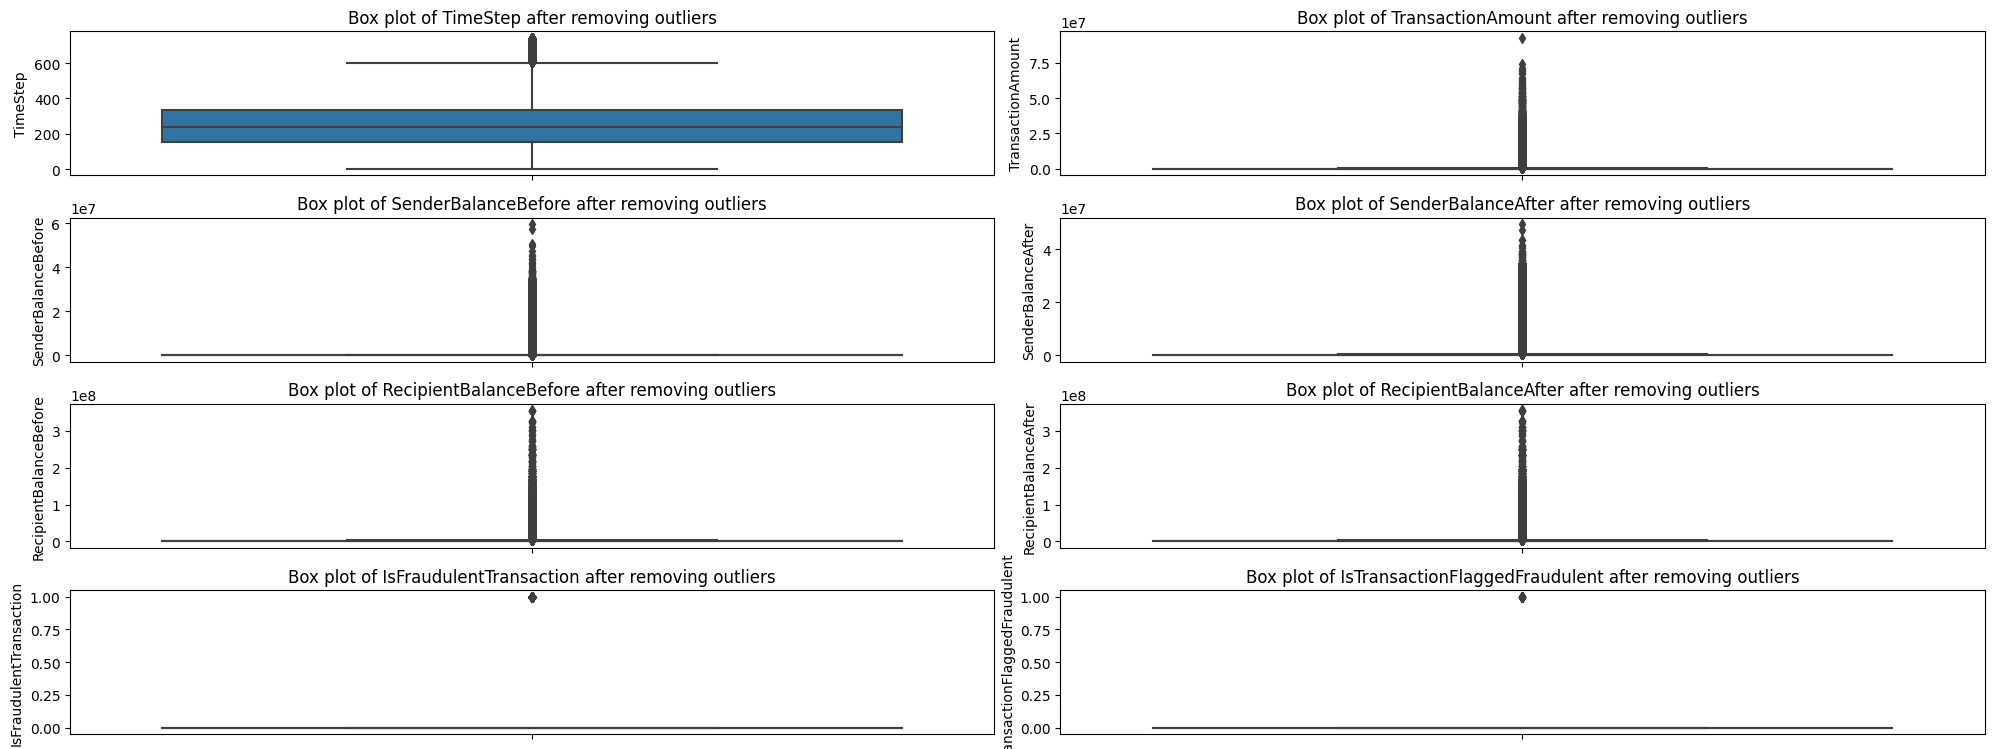

In [12]:
# Plot box plots for each numeric column after outlier removal
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col} after removing outliers')
plt.tight_layout()
plt.show()

Considering the nature of our dataset (fraud detection), keeping outliers might be crucial since they could represent fraudulent transactions. Instead of removing them, we could focus on techniques that are robust to outliers or specifically designed to identify anomalous patterns as potentially interesting or suspicious. This approach allows you to preserve and even highlight the most critical aspects of our dataset related to fraud detection.

In [13]:
# # Define a function to remove outliers based on the Z-score method
# def remove_outliers(df, cols):
#     z_scores = stats.zscore(df[cols])
#     abs_z_scores = np.abs(z_scores)
#     filtered_entries = (abs_z_scores < 3).all(axis=1)
#     return df[filtered_entries]

# # Apply the function to remove outliers from the DataFrame
# df_cleaned = remove_outliers(df, numerical_cols)

Let's Check the Outliers after using `z-score` to deal

In [14]:
# # Plot box plots for each numeric column after outlier removal
# plt.figure(figsize=(20, 15))
# for i, col in enumerate(numerical_cols):
#     plt.subplot(len(numerical_cols), 2, i+1)
#     sns.boxplot(y=df_cleaned[col])
#     plt.title(f'Box plot of {col} after removing outliers')
# plt.tight_layout()
# plt.show()

## Data Analysis and Discovering Patterns

In this section, we focus on summarizing the data to uncover hidden insights. We will conduct various analyses to understand the data better and identify any underlying patterns or anomalies that could inform our decision-making process or predictive modeling.

### **Case 1: Analyze the Total Transaction Amount for each Transaction Type**

This analysis case focuses on understanding the total transaction amounts for each type of transaction.


In [15]:
total_amount_by_type = df.groupby('TransactionType')['TransactionAmount'].sum().reset_index()
total_amount_by_type['TransactionAmount'] = total_amount_by_type['TransactionAmount'].apply(lambda x: f"{x / 1e9:.2f} Billion")
total_amount_by_type

,TransactionType,TransactionAmount
0,CASH_IN,236.37 Billion
1,CASH_OUT,394.41 Billion
2,DEBIT,0.23 Billion
3,PAYMENT,28.09 Billion
4,TRANSFER,485.29 Billion


### **Case 2: Identify Top 10 Accounts with High Frequency of Transactions**

This case is about finding accounts that are very active in terms of the number of transactions.

In [16]:
transaction_count_sender = df['SenderAccountId'].value_counts().reset_index().head(10)
transaction_count_sender.columns = ['SenderAccountId', 'TransactionCount']
transaction_count_sender

,SenderAccountId,TransactionCount
0,C1902386530,3
1,C363736674,3
2,C545315117,3
3,C724452879,3
4,C1784010646,3
5,C1677795071,3
6,C1462946854,3
7,C1999539787,3
8,C2098525306,3
9,C400299098,3


### **Case 3: Detect Changes in Account Balance Post-Transaction**

Understanding how account balances change after transactions can help in detecting anomalies.

Let's Go Bro

In [17]:
# Calculate the balance change
df['SenderBalanceChange'] = df['SenderBalanceBefore'] - df['SenderBalanceAfter']

# Identify large changes as those in the top 5% of balance changes
large_changes = df[df['SenderBalanceChange'].abs() > df['SenderBalanceChange'].quantile(0.95)]

# Selecting and sorting the columns of interest
large_changes = large_changes[['SenderAccountId', 'SenderBalanceBefore', 'SenderBalanceAfter', 'SenderBalanceChange']].copy()

# Sorting the results by the absolute value of the balance change in descending order for better readability
large_changes = large_changes.sort_values(by='SenderBalanceChange', key=abs, ascending=False)

# Formatting the balance and change columns for readability: round the values and add thousands separator
large_changes['SenderBalanceBefore'] = large_changes['SenderBalanceBefore'].map('${:,.2f}'.format)
large_changes['SenderBalanceAfter'] = large_changes['SenderBalanceAfter'].map('${:,.2f}'.format)
large_changes['SenderBalanceChange'] = large_changes['SenderBalanceChange'].map('${:,.2f}'.format)

large_changes.reset_index(drop=True, inplace=True)
large_changes.head(10)

,SenderAccountId,SenderBalanceBefore,SenderBalanceAfter,SenderBalanceChange
0,C671111468,"$37,418,265.31","$27,418,265.31","$10,000,000.00"
1,C794290057,"$42,542,664.27","$32,542,664.27","$10,000,000.00"
2,C1421664654,"$34,892,193.09","$24,892,193.09","$10,000,000.00"
3,C524119157,"$19,228,514.10","$9,228,514.10","$10,000,000.00"
4,C1295280435,"$23,752,520.60","$13,752,520.60","$10,000,000.00"
5,C315155195,"$22,625,132.51","$12,625,132.51","$10,000,000.00"
6,C1074619527,"$19,110,884.44","$9,110,884.44","$10,000,000.00"
7,C292642955,"$23,576,297.10","$13,576,297.10","$10,000,000.00"
8,C1180822515,"$10,000,000.00",$0.00,"$10,000,000.00"
9,C517014062,"$10,000,000.00",$0.00,"$10,000,000.00"


### **Case 4: Fraud Analysis Based on Transaction Amount**

This analysis aims to find if the transaction amount is related to fraudulent activities.

In [18]:
fraud_amount_stats = df.groupby('IsFraudulentTransaction')['TransactionAmount'].describe()
fraud_amount_stats

,count,mean,std,min,25%,50%,75%,max
IsFraudulentTransaction,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


* Transaction Amounts: Fraudulent transactions have significantly higher average and median amounts than non-fraudulent ones, suggesting that when fraud occurs, it's likely to involve larger sums of money.
* Variability: The standard deviation is larger for fraudulent transactions, indicating a greater spread in the amounts, which could be due to the varied nature of fraudulent activities.
* Distribution: The distribution of transaction amounts for both fraudulent and non-fraudulent transactions is skewed, with a long tail of higher values, as indicated by the mean being much higher than the median in both cases.

### **Case 5: Analyze Flagged Fraudulent Transactions**
This case investigates the transactions that have been flagged as fraudulent.

In [19]:
flagged_fraud_transactions = df[df['IsTransactionFlaggedFraudulent'] == 1]
flagged_fraud_transactions['TransactionAmount'] = flagged_fraud_transactions['TransactionAmount'].map('${:,.2f}'.format)
flagged_fraud_transactions['SenderBalanceBefore'] = flagged_fraud_transactions['SenderBalanceBefore'].map('${:,.2f}'.format)
flagged_fraud_transactions['SenderBalanceAfter'] = flagged_fraud_transactions['SenderBalanceAfter'].map('${:,.2f}'.format)
# flagged_fraud_transactions['SenderBalanceChange'] = flagged_fraud_transactions['SenderBalanceChange'].map('${:,.2f}'.format)

flagged_fraud_transactions.head(10)

,TimeStep,TransactionType,TransactionAmount,SenderAccountId,SenderBalanceBefore,SenderBalanceAfter,RecipientAccountId,RecipientBalanceBefore,RecipientBalanceAfter,IsFraudulentTransaction,IsTransactionFlaggedFraudulent,SenderBalanceChange
2736446,212,TRANSFER,"$4,953,893.08",C728984460,"$4,953,893.08","$4,953,893.08",C639921569,0.0,0.0,1,1,0.0
3247297,250,TRANSFER,"$1,343,002.08",C1100582606,"$1,343,002.08","$1,343,002.08",C1147517658,0.0,0.0,1,1,0.0
3760288,279,TRANSFER,"$536,624.41",C1035541766,"$536,624.41","$536,624.41",C1100697970,0.0,0.0,1,1,0.0
5563713,387,TRANSFER,"$4,892,193.09",C908544136,"$4,892,193.09","$4,892,193.09",C891140444,0.0,0.0,1,1,0.0
5996407,425,TRANSFER,"$10,000,000.00",C689608084,"$19,585,040.37","$19,585,040.37",C1392803603,0.0,0.0,1,1,0.0
5996409,425,TRANSFER,"$9,585,040.37",C452586515,"$19,585,040.37","$19,585,040.37",C1109166882,0.0,0.0,1,1,0.0
6168499,554,TRANSFER,"$3,576,297.10",C193696150,"$3,576,297.10","$3,576,297.10",C484597480,0.0,0.0,1,1,0.0
6205439,586,TRANSFER,"$353,874.22",C1684585475,"$353,874.22","$353,874.22",C1770418982,0.0,0.0,1,1,0.0
6266413,617,TRANSFER,"$2,542,664.27",C786455622,"$2,542,664.27","$2,542,664.27",C661958277,0.0,0.0,1,1,0.0
6281482,646,TRANSFER,"$10,000,000.00",C19004745,"$10,399,045.08","$10,399,045.08",C1806199534,0.0,0.0,1,1,0.0


In [20]:
df.head()

,TimeStep,TransactionType,TransactionAmount,SenderAccountId,SenderBalanceBefore,SenderBalanceAfter,RecipientAccountId,RecipientBalanceBefore,RecipientBalanceAfter,IsFraudulentTransaction,IsTransactionFlaggedFraudulent,SenderBalanceChange
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14


### **Case 6: Analyze the Impact of Transaction Amount on Account Balance Difference**

Understanding how transaction amounts impact the balance difference can reveal insights into transaction behaviors.



In [21]:
df['SenderBalanceChange'] = df['SenderBalanceBefore'] - df['SenderBalanceAfter']
df['RecipientBalanceChange'] = df['RecipientBalanceAfter'] - df['RecipientBalanceBefore']

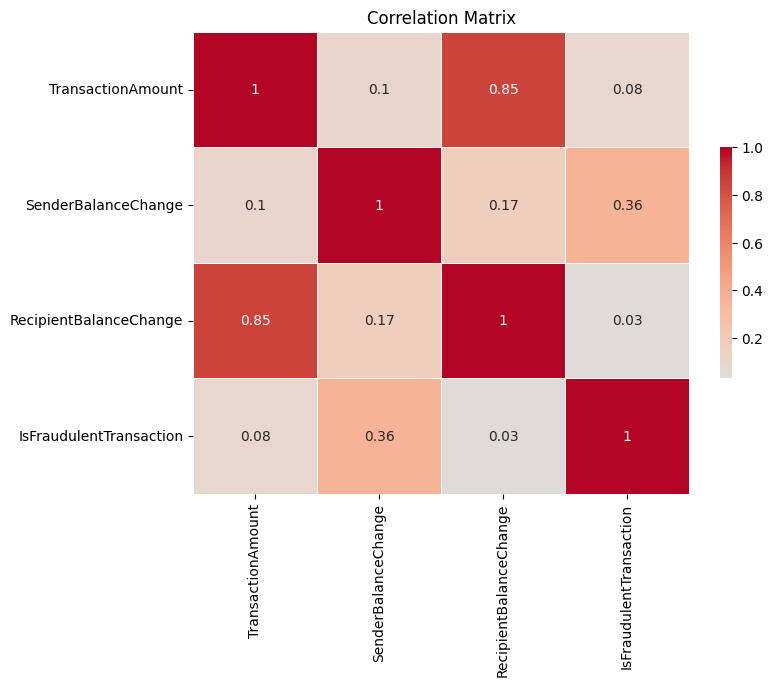

In [22]:
balance_diff_analysis = df[['TransactionAmount', 'SenderBalanceChange', 'RecipientBalanceChange', 'IsFraudulentTransaction']].corr()

balance_diff_analysis_rounded = balance_diff_analysis.round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(balance_diff_analysis_rounded, annot=True, cmap='coolwarm', center=0,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

### **Case 7: Examine TimeStep for Patterns in Fraudulent Transactions**

Investigate if there's a specific time when fraudulent transactions are more prevalent.

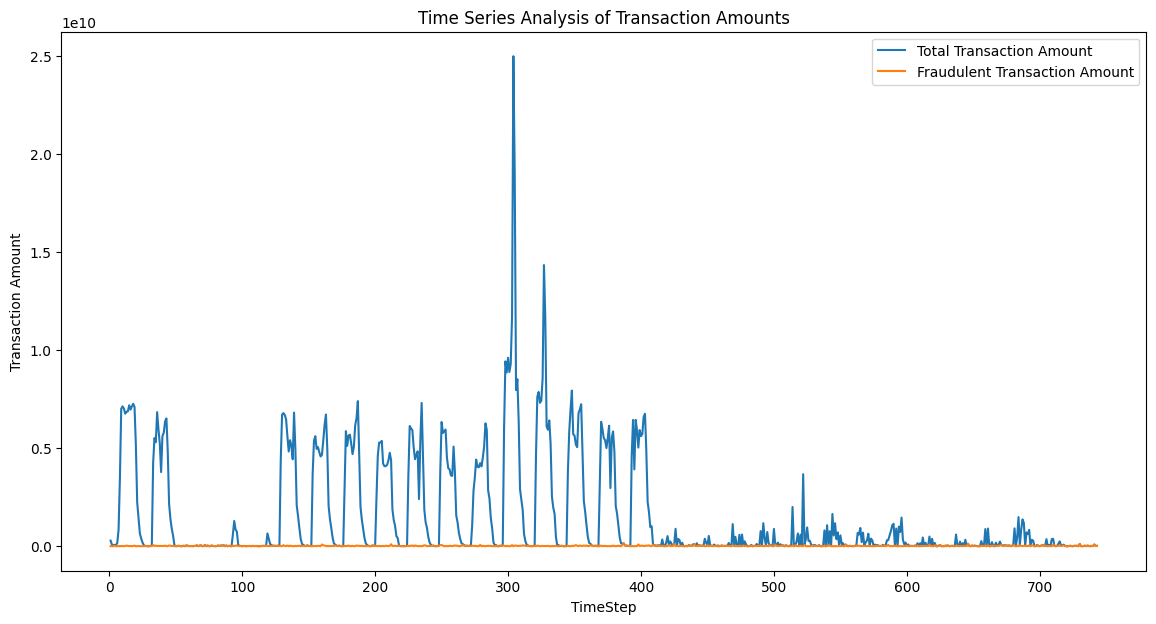

In [23]:
time_series_data = df.groupby('TimeStep').agg(
    TotalAmount=('TransactionAmount', 'sum'),
    FraudAmount=('TransactionAmount', lambda x: x[df.loc[x.index, 'IsFraudulentTransaction'] == 1].sum())
).reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=time_series_data, x='TimeStep', y='TotalAmount', label='Total Transaction Amount')
sns.lineplot(data=time_series_data, x='TimeStep', y='FraudAmount', label='Fraudulent Transaction Amount')
plt.title('Time Series Analysis of Transaction Amounts')
plt.xlabel('TimeStep')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

### **Case 8: Fraudulent Transactions Amount Distribution**

Investigate the distribution of transaction amounts for fraudulent vs. non-fraudulent transactions to see if fraudulent transactions tend to be larger or smaller.

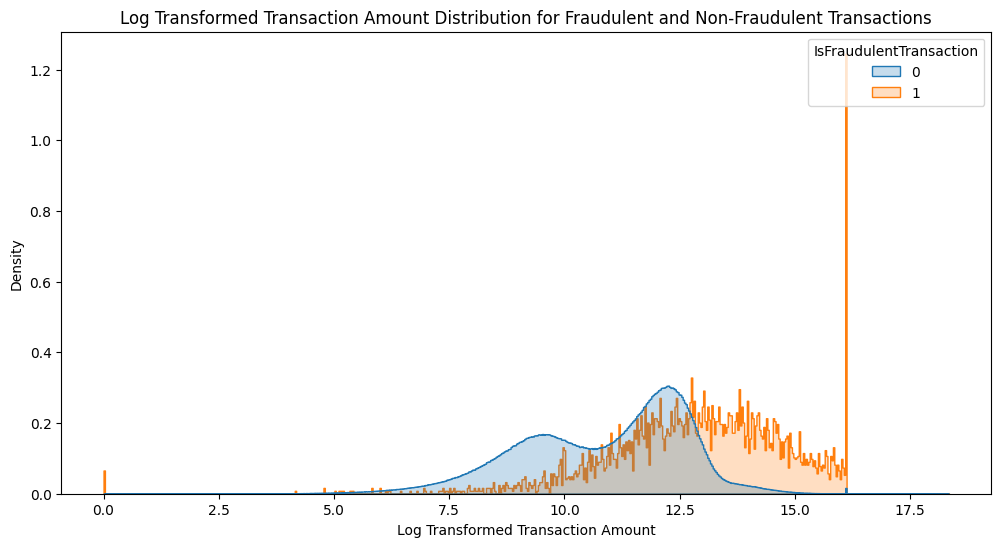

In [24]:
df['TransactionAmountLog'] = np.log(df['TransactionAmount'] + 1)  # Adding 1 to avoid log(0)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='TransactionAmountLog', hue='IsFraudulentTransaction', element='step', common_norm=False, stat='density')
plt.title('Log Transformed Transaction Amount Distribution for Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Log Transformed Transaction Amount')
plt.show()

### **Case 9: Scatter Plot of Balance Changes**

Analyze the relationship between the balance changes in sender and recipient accounts to see if patterns emerge, especially in fraudulent transactions.

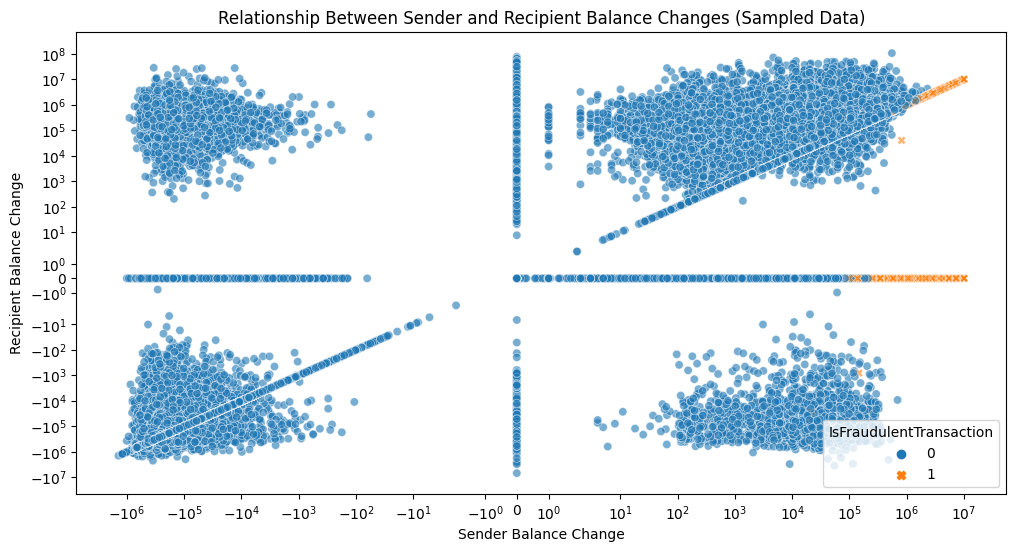

In [25]:
df_sampled = df.sample(frac=0.1, random_state=1)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_sampled, x='SenderBalanceChange', y='RecipientBalanceChange', hue='IsFraudulentTransaction', style='IsFraudulentTransaction', alpha=0.6)
plt.title('Relationship Between Sender and Recipient Balance Changes (Sampled Data)')
plt.xlabel('Sender Balance Change')
plt.ylabel('Recipient Balance Change')
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()

## Feature Engineering
### 1. Categorical Encoding

We have `Type` include:
- CASH_IN
- CASH_OUT
- DEBIT
- PAYMENT
- TRANSFER
Thus, we will use `LabelEncoder`

In [26]:
encoder = LabelEncoder()
df['TransactionType'] = encoder.fit_transform(df['TransactionType'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   TimeStep                        int64  
 1   TransactionType                 int64  
 2   TransactionAmount               float64
 3   SenderAccountId                 object 
 4   SenderBalanceBefore             float64
 5   SenderBalanceAfter              float64
 6   RecipientAccountId              object 
 7   RecipientBalanceBefore          float64
 8   RecipientBalanceAfter           float64
 9   IsFraudulentTransaction         int64  
 10  IsTransactionFlaggedFraudulent  int64  
 11  SenderBalanceChange             float64
 12  RecipientBalanceChange          float64
 13  TransactionAmountLog            float64
dtypes: float64(8), int64(4), object(2)
memory usage: 679.6+ MB


Drop any useless columns for ML Model
- SenderAccountId
- RecipientAccountId

In [28]:
df.drop(['SenderAccountId', 'RecipientAccountId'], axis=1, inplace=True)

## Split the Data

In [29]:
X = df[['TimeStep', 'TransactionType', 'TransactionAmount','SenderBalanceBefore','SenderBalanceAfter', 'RecipientBalanceBefore', 'RecipientBalanceAfter']]
y = df[['IsFraudulentTransaction']]

## Resampling the Imbalanced Data

We will use `Undersampling Method`

In [30]:
# Undersampling:
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X, y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.7, random_state=111)

In [32]:
#Checking for balance in target
import plotly.graph_objects as go
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=y_res['IsFraudulentTransaction'].value_counts())])
fig.show()

## Data Standardization

In [33]:
#Standardizing the numerical columns
col_names= ['TransactionAmount','SenderBalanceBefore','SenderBalanceAfter']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] =features_test

In [34]:
#creating the objects
logreg_cv = LogisticRegression(solver='liblinear',random_state=123)
dt_cv=DecisionTreeClassifier(random_state=123)
knn_cv=KNeighborsClassifier()
rf_cv=RandomForestClassifier(random_state=123)
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Random Forest'}
cv_models=[logreg_cv,dt_cv,knn_cv,rf_cv]

for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X_train, y_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.6064534756120634
Decision Tree Test Accuracy: 0.9877364059484618
KNN Test Accuracy: 0.8230999356718508
Random Forest Test Accuracy: 0.99060687932796


## Model Evaluation

In [35]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 4, 8],
    'min_samples_split': [2, 5, 10],
}
# Create the Random Forest classifier
rfc = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and its parameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_params)

# Evaluate the best model on the test data
y_pred = best_estimator.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)

Best parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 500}
Test accuracy: 0.984577922077922


## Test New Data

In [36]:
new_data = pd.DataFrame({
    'TimeStep': [5],
    'TransactionType': [1],
    'TransactionAmount': [20000],
    'SenderBalanceBefore': [50000],
    'SenderBalanceAfter': [30000],
    'RecipientBalanceBefore': [100000],
    'RecipientBalanceAfter': [120000]
})

new_predictions = grid_search.predict(new_data)
print("New predictions for Fraud or Not:", new_predictions)

New predictions for Fraud or Not: [1]


# Save the Model

In [37]:
dump(grid_search, 'model.pkl')

print("Model saved successfully.")

Model saved successfully.
